# 7CUSMSDA_Week5_Buffering & Spatial Interpolation
<a href="#This Week's Overview">This Week's Overview</a>

<a href="#Learning Outcomes">Learning Outcomes</a>

<a href="#Get prepared">Get prepared</a>
  - <a href='#Import libraries'>Import libraries</a>
  - <a href='#Read the data'>Read the data</a>
  
<a href='#Voronoi diagram'>Voronoi diagram</a>
  - <a href='#Warm up with sample points'>Warm up with sample points</a>
  - <a href='#Work with full dataset'>Work with full dataset</a>
  - <a href='#Trimming by bbox'>Trimming by bbox</a>    
  - <a href='#Voronoi weights'>Voronoi weights</a>
  - <a href='#Voronoi visualization'>Voronoi visualization</a>

<a href='#Delaunay Triangulations'>Delaunay Triangulations</a>
  - <a href='#Coplanar Points'>Coplanar Points<a/>

<a href='#Convex Hulls'>Convex Hulls<a/> (Optional)

<a href='#Buffering'>Buffering</a>

<a href='#Interpolation'>Interpolation</a>
- <a href='#Basic Interpolation'>Basic Interpolation</a>
- <a href='#IDW Interpolation'>IDW Interpolation</a>
- <a href='#Kriging Interpolation'>Kriging Interpolation</a>
  - <a href='#2D Kriging Calculation'>2D Kriging Calculation</a> 
  - <a href='#2D Kriging Visualization'>2D Kriging Visualization</a> 
      

- <a href="#Task 1">Task 1</a>
- <a href="#Task 2">Task 2</a>
- <a href="#Task 3">Task 3</a>
- <a href="#Task 4">Task 4</a>
- <a href="#Task 5">Task 5</a>
- <a href="#Task 6">Task 6</a>
- <a href="#Task 7">Task 7</a> 
- <a href="#Task 8">Task 8</a>
- <a href="#Task 9">Task 9</a>

## <a id="This Week's Overview">This Week's Overview</a>

For this practical, based on our familiarity with point pattern analysis since last week, we will further explore the distribution of **London stations** as point data, and try to simulate the density of **passengers' entries** in 2018 from [TfL](http://crowding.data.tfl.gov.uk/) as an example. To realize both goals, we will recall our knowledge from the lecture on drawing voronoi diagram, building up buffers and conducting kriging interpolation. Hence specific packages like `scipy.spatial`, `scipy.interpolate`, `pykrige` will be used to play the functionality. 

## <a id='Learning Outcomes'> Learning Outcomes</a>
We will look at ways to measure distance and proximity (produce buffers), starting with tessellate space (Voronoi diagrams).
By the end of this practical, you should be able to
- Understand the notions of Voronoi diagrams (VDs) and Delaunay tessellations (DTs).
- Generate VDs and DTs.
- Enhance your understanding of the definition and role of a convex hull.

## <a id='Get prepared'> Get prepared</a> 
### <a id='Import libraries'> Import libraries</a>

In [1]:
# general requirements
import sys
import urllib
import zipfile
import os
sys.path.append(os.path.abspath('..'))
import libpysal
from libpysal.cg.voronoi import voronoi, voronoi_frames
import numpy as np
import pandas as pd
import scipy.spatial as spatial
%matplotlib inline
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

# voronoi weights
from libpysal.weights.contiguity import Voronoi as Vornoi_weights
# voronoi plot
from scipy.spatial import Voronoi, voronoi_plot_2d
# voronoi streetmap visualization
import smopy

# spatial delaunay and visualization
from scipy.spatial import Delaunay, delaunay_plot_2d
import matplotlib.tri as mpltri
import math
# convex hull and visualization
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import shapely
from shapely.geometry.polygon import Polygon

# interpolation and kriging interpolation
import glob
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
import pykrige.kriging_tools as kt

import scipy.optimize
import scipy.interpolate
 
import random
import folium
import branca.colormap as cm
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Path, PathPatch

# ignore warnings message presence
import warnings
warnings.simplefilter('ignore')

### <a id='Read the data'> Read the data</a>

This week, we are expected to realize 3 main tasks: Voronoi diagram visualization, buffering, and spatial interpolation, using 2 main datasets.

In [2]:
# Create the data dir if it doesn't exist
if os.path.isdir('data') is not True:
    print("Creating 'data' directory...")
    os.mkdir('data')

# Configure the download
url  = 'https://github.com/cusp-london/Spatial-Data-Analysis/blob/master/Stations%202018.csv?raw=true'
path = os.path.join("data","Stations 2018.csv")

# Download
r    = urllib.request.urlretrieve(url, path)

In [4]:
stations=pd.read_csv('data/Stations 2018.csv')

In [5]:
print (len(stations))

479


How many stations recorded in the dataset? **----------------**

## <a id='Voronoi diagram'> Voronoi diagram</a> 

You had already been introduced the [Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram#Formal_definition) this week, which partitions set of points into regions based on distances. Within the set of points, or so-called seeds, each one will have its corresponding region with all points closer than others, and these regions are Voronoi cells (or polygons) due to their similar shape to cell. You may also explore the definition of its [Delaunay triangulation](http://mathworld.wolfram.com/DelaunayTriangulation.html). The definition of [distance metric space](https://en.wikipedia.org/wiki/Metric_space) is crucial to Voronoi diagram. 

Voronoi diagrams have practical applications in many fields, i.e. in mesh generation, point location, cluster analysis, machining plans. For example, the Vornonoi diagram for a point locational dataset can help to make nearest neighbor queries, e.g. the nearest hospital near a community; to find the largest empty circle amid a set of points, and in an enclosing polygon, e.g. to build a new supermarket as far as possible from all the existing ones in a city.

### <a id='Warm up with sample points'> Warm up with sample points</a>  
We are going to learn the basis of Voronoi by using `PySAL` as the starting point. We use the 10 sample station coordinates as example to get you familiar with the elementary features in Voronoi, i.e. regions and vertices.

In [5]:
# view information for 10 sample stations
stations.head(10)  # your code here

FID  OBJECTID               NAME  EASTING  NORTHING  \
0  291       477         Abbey Road   539077    183399   
1  258       162      Acton Central   520632    180296   
2  225       204         Acton Town   519478    179592   
3  455       421  Addington Village   537066    163744   
4  422       425         Addiscombe   534188    166297   
5    6        84            Aldgate   533613    181262   
6   61       249       Aldgate East   533936    181375   
7  170       448         All Saints   537979    180993   
8  309        13           Alperton   517996    183795   
9  472       284           Amersham   496372    198181   

                          LINES             NETWORK  Zone         x          y  
0                           NaN                 DLR     3  0.005308  51.531865  
1                           NaN   London Overground     3 -0.261566  51.508218  
2          District, Piccadilly  London Underground     3 -0.278433  51.502137  
3                           NaN            Tramlink     6 -0.031284  51.355710  
4                           NaN            Tramlink     5 -0.071626  51.379342  
5          Metropolitan, Circle  London Underground     1 -0.074236  51.513982  
6  Hammersmith & City, District  London Underground     1 -0.069540  51.514917  
7                           NaN                 DLR     2 -0.011456  51.510512  
8                    Piccadilly  London Underground     4 -0.298361  51.540227  
9                  Metropolitan  London Underground     9 -0.606147  51.673662

Upon calling `voronoi` function, you will get features like `regions` and `vertices`. Check the data type and discuss with your neighours about your observation: what do you think they refer to? what is the meaning? how to interpret the outputs you got?

In [7]:
# copy and paste the 10 sample stations' coordinates information (x and y) below, should be 10 pairs
pts_sample = [(0.005308, 51.531865), (-0.261566, 51.508218), (-0.278433, 51.502137), \
              (-0.031284, 51.355710), (-0.071626, 51.379342), (-0.074236, 51.513982),\
              (-0.069540, 51.514917), (-0.011456, 51.510512), (-0.298361,51.540227), (-0.606147, 51.673662)]
# call voronoi function
regions_sample, vertices_sample = voronoi(pts_sample)
regions_sample

[[0, 4, 3, 1, 16, 15],
 [14, 6, 2, 12],
 [14, 12, 11, 13],
 [18, 17, 1, 9, 8],
 [14, 6, 7, 10, 9, 8, 13],
 [7, 5, 2, 6],
 [10, 3, 4, 5, 7],
 [10, 3, 1, 9],
 [12, 2, 5, 4, 0, 11],
 [20, 8, 13, 11, 0, 19]]

In [8]:
vertices_sample

array([[-1.23705863e-01,  5.23647855e+01],
       [ 1.34552506e-01,  5.14131395e+01],
       [-1.72119207e-01,  5.16481917e+01],
       [-3.77884499e-02,  5.15484424e+01],
       [-1.34432236e-01,  5.19752535e+01],
       [-1.44862162e-01,  5.18809593e+01],
       [-1.65862862e-01,  5.14448605e+01],
       [-5.84470310e-02,  5.14469428e+01],
       [-6.29732961e+00,  4.07052429e+01],
       [-1.36175462e-02,  5.14321180e+01],
       [-4.55011315e-02,  5.14467436e+01],
       [-5.48409829e-01,  5.13851480e+01],
       [-2.77773383e-01,  5.15267401e+01],
       [-3.08011282e+00,  4.65481008e+01],
       [-2.19665527e-01,  5.13655651e+01],
       [ 2.34969501e+01,  1.54221441e+02],
       [ 1.02508765e+02,  3.01473384e+01],
       [ 1.02508765e+02,  3.01473384e+01],
       [-5.69036176e+01, -5.07918463e+01],
       [ 2.34969501e+01,  1.54221441e+02],
       [-5.69036176e+01, -5.07918463e+01]])

In [9]:
# read the features into dataframes for further use
region_sample_df, pts_sample_df = voronoi_frames(pts_sample)

In [10]:
region_sample_df.head(3)

geometry
0  POLYGON ((0.00531 51.51461, -0.03779 51.54844,...
1  POLYGON ((-0.21967 51.36557, -0.27777 51.52674...
2  POLYGON ((-0.21967 51.36557, -0.22552 51.35571...

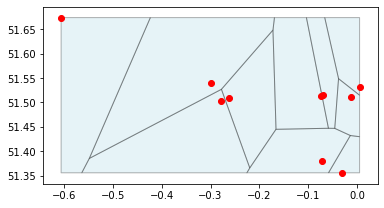

In [9]:
# get the sample frame and point plotted
fig, ax = plt.subplots()
region_sample_df.plot(ax=ax, color='lightblue',edgecolor='black', alpha=0.3)
pts_sample_df.plot(ax=ax, color='red')

### <a id='Work with full dataset'> Work with full dataset</a> 
Happy with the sample test so far? Now let's try to explore the full dataset. We need to start with defining the points, right? However, what type of points data are you expecting? It may need your recap on last week's practical.

In [11]:
# points should be array
# google function 'vstack' from numpy
points = np.vstack([stations['x'], stations['y']]).T 
# call voronoi function
results = voronoi(points)
# define minimum and maximum locations of the points
mins = points.min(axis=0)
maxs = points.max(axis=0)

### <a id="Task 1">Task 1</a>
Follow the example given with sample data, and get the full stations data plotted:

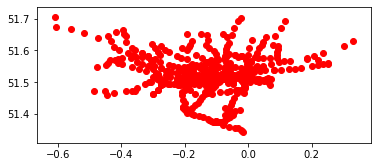

In [12]:
# your codes below
# call voronoi for full dataset

# write into dataframes
region_stations_df, pts_stations_df = voronoi_frames(points)


# plot the points
fig, ax = plt.subplots()
pts_stations_df.plot(ax=ax, color='red')


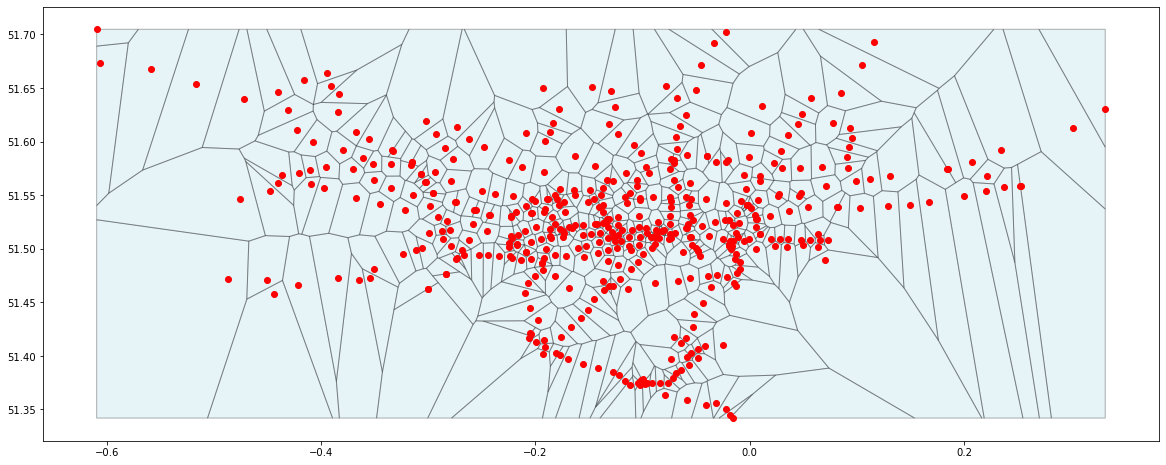

In [22]:
# plot the voronoi frames and points together
fig, ax = plt.subplots(figsize=(20,20))
region_stations_df.plot(ax=ax, color='lightblue',edgecolor='black', alpha=0.3)
pts_stations_df.plot(ax=ax, color='red')

### <a id='Trimming by bbox'> Trimming by bbox</a> 
This bbox has the similar 'function' as a rectangle window, so it could be used as clipper to "cut" the points.

In [13]:
# define a bounding box as clipper
# call the minimum and maximum locational data for points
xr = maxs[0] - mins[0]
yr = maxs[1] - mins[1]
# define a buffer area
buff = 0.05
r = max(yr, xr) * buff
minx = mins[0] - r
miny = mins[1] - r
maxx = maxs[0] + r
maxy = maxs[1] + r

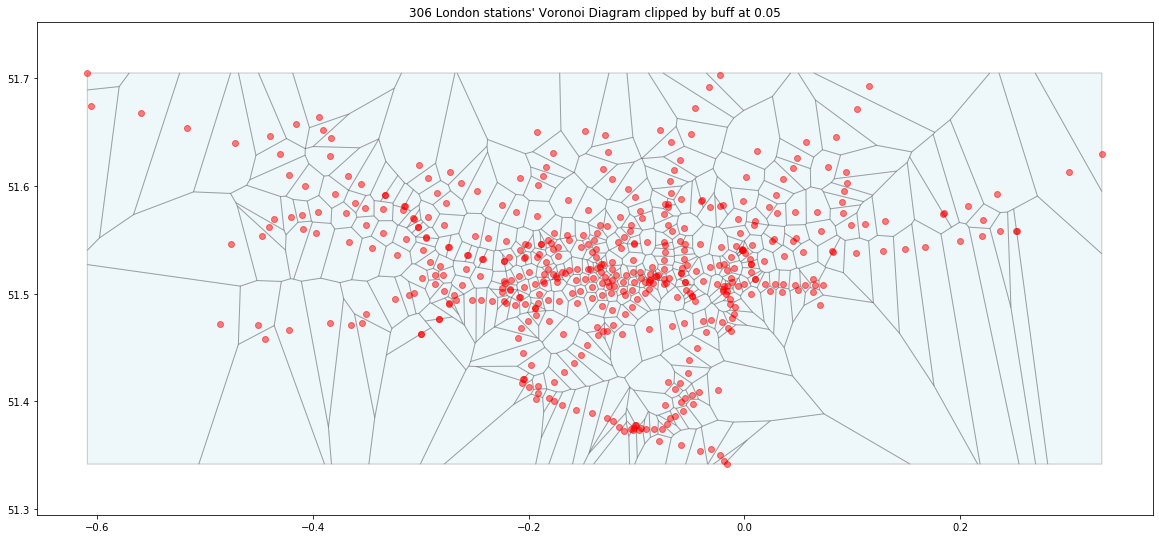

In [38]:
fig, ax = plt.subplots(figsize=(20,20))
region_stations_df.plot(ax=ax, edgecolor='black', facecolor='lightblue', alpha=0.2 )
pts_stations_df.plot(ax=ax, color='red', alpha=0.5 )
plt.xlim(minx, maxx)
plt.ylim(miny, maxy)
plt.title("306 London stations' Voronoi Diagram clipped by buff at 0.05")
plt.show()

### <a id='Voronoi weights'> Voronoi weights</a> 
If we want to get detailed information from `voronoi diagram`, we need call `vornoi weights` function, to get the matrix of vornoi weights. The $number  of  units$ should be equal to the number of points.

In [14]:
w = Vornoi_weights(points)
w.n #number of points

479

However, there might be some weights with value at 0, so in order to get the number of nonzero weights, we can call `nonzero`; to measure the percentage of nonzero weights, we can call `pct_nonzero`. More interpretation of the outputs could be found from [here](https://pysal.readthedocs.io/en/latest/generated/pysal.lib.weights.W.html). Please discuss with your neighbors, why the number of weights is larger than number of points? What is the difference between units and weights?

In [15]:
w.nonzero

2708

In [16]:
w.pct_nonzero

1.1802598489371996

If we want to know further which units are defined as neighbors for target observation, we can simply try to call `neighbors`; and the frequency statistics for neighbors could be achieved by calling `histogram`. Could you try to interpret the output by yourself then?

In [42]:
w.neighbors

{0: [449, 450, 55, 393, 266, 315],
 1: [2, 88, 361, 122, 444, 285, 413],
 2: [1, 231, 361, 170, 171, 362, 120, 444],
 3: [146, 165, 135, 28, 14],
 4: [100, 245, 296, 41, 347, 476],
 5: [357, 6, 409, 410, 253, 254, 255],
 6: [465, 5, 357, 409, 351],
 7: [243, 44, 317],
 8: [387, 181, 310, 119, 441, 396],
 9: [80, 84],
 10: [402, 424, 105, 446, 447],
 11: [309, 39, 296, 105, 186],
 12: [64, 202, 75, 299, 237, 145, 82, 22],
 13: [419, 163, 103, 411, 203],
 14: [3, 100, 165, 135, 186, 476],
 15: [48, 97, 375, 408, 203, 124],
 16: [262, 103, 150, 201, 75, 207],
 17: [135, 29, 309, 39],
 18: [81, 265, 378, 267, 332, 45],
 19: [33, 402, 404, 53, 93, 95],
 20: [273, 275, 21, 264, 253, 255],
 21: [264, 273, 74, 20],
 22: [145, 275, 379, 299, 12],
 23: [24, 217, 348, 125, 30],
 24: [418, 23, 154, 348, 30],
 25: [144, 162, 155, 284],
 26: [224, 321, 354, 307, 177, 455],
 27: [305, 341, 326, 297],
 28: [3, 135, 399, 209, 146, 247, 152, 29],
 29: [17, 309, 135, 28, 399],
 30: [340, 23, 24, 154, 108

In [45]:
w.histogram

[(1, 3),
 (2, 10),
 (3, 24),
 (4, 67),
 (5, 119),
 (6, 130),
 (7, 75),
 (8, 24),
 (9, 18),
 (10, 8),
 (11, 1)]

From the above result, we can tell the minimum number of neighbors is 1, and the maximum neighbors are 11; the most frequent number of neighbors is 6, which occured 130 times. Try to add the frequencies together, you will find the total number is 479.

As you may find there are 10 observations have 2 neighbors, so if we want to locate where they exactly are, we can call `cardinalities` to get their coordinates as below.

In [46]:
# cardinalities is the number of neighbors for each observation
id_2 = [i for i in range(w.n) if w.cardinalities[i]==2]
points[id_2]

array([[-6.06146762e-01,  5.16736619e+01],
       [-5.59159868e-01,  5.16675465e+01],
       [-4.44145672e-01,  5.14580295e+01],
       [-4.86475608e-01,  5.14720165e+01],
       [-3.54755400e-01,  5.14727522e+01],
       [-1.86651960e-02,  5.13448509e+01],
       [-1.93160282e-01,  5.14020167e+01],
       [-3.00084253e-01,  5.14626059e+01],
       [-1.11770014e-01,  5.13729387e+01],
       [-3.94615064e-01,  5.16634936e+01]])

### <a id="#Voronoi visualization">Voronoi visualization</a>
Once you are familiar with the features of Voronoi and Voronoi weights, let's start to use `scipy.spatial` package to practice your capability in computing Voronoi Diagrams, Delaunay Triangulations and Convex Hulls of points, by leveraging the [Qhull library](http://www.qhull.org/). It also links to what we've practiced last week on KDTree implementations for nearest neighbor point queries, as well as distance computations in various metrics. The visualization of results will still mainly rely on `matplotlib.pyplot`, but we will step further by using `Smopy`.

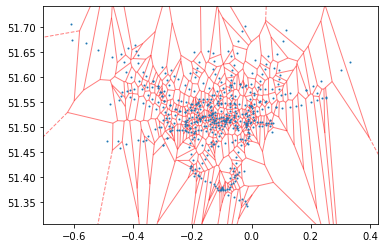

In [17]:
# load geo-locational variables of London stations
points = np.vstack([stations['x'], stations['y']]).T # hint: points should be array  
# plot voronoi diagram by using matplotlib
vor = Voronoi(points)
fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='red', line_width=1, line_alpha=0.5, point_size=2)
plt.show()

We chose to not show vertices for the above plot, trying to avoid mixing up the points and vertices, but you are encourged to make them visible for your research purpose by simply defining show_vertices as "True". Try it and see what is the difference.

As vertices is crucial element in building up a voronoi diagram, we want to read the values for vertices by calling: 

In [51]:
vor.vertices # locational information on nodes equidistant to three (or more) sites

array([[-0.31214051, 52.67293392],
       [ 0.27273688, 51.25764088],
       [-0.62053224, 50.07734359],
       ...,
       [-0.0651142 , 51.54181681],
       [-0.08278316, 51.54242948],
       [-0.08234887, 51.54463455]])

In [52]:
vor.regions # indices for each voronoi polygon

[[15, 11, 10, -1, 0, 14],
 [34, 32, 33],
 [34, 19, 17, 16, 32],
 [33, 18, 21, 20, 3, -1, 4, 5, 1, 28, 26, 16, 32],
 [62, 56, 57, 58, 61],
 [79, 6, 24, 48, 49, 76],
 [77, 75, 49, 76],
 [88, 10, 11, 86],
 [88, 10, -1, 87],
 [90, 78, 77, 76, 79, 80, 89],
 [97, 92, 91, 35, 95],
 [98, 40, 66, 65, 42, 41, 93, 92, 97],
 [100, 96, 95, 97, 98, 99],
 [109, 42, 41, 39, 108],
 [112, 44, 43, 111],
 [115, 99, 98, 40, 113],
 [123, 53, 35, 95, 96, 36, 104, 105, 38, 122],
 [126, 103, 38, 122, 120, 54, 124],
 [130, 25, 27, 127],
 [128, 55, 29, 27, 127],
 [129, 62, 56, 55, 128],
 [132, 57, 56, 55, 29, 28, 1, 131],
 [142, 66, 40, 113, 114, 45, 47, 46, 63, 141],
 [145, 142, 141, 140, 139, 144],
 [155, 150, 152, 153, 151, 154],
 [165, 161, 160, 162, 163, 164],
 [165, 156, 157, 161],
 [163, 155, 154, 70, 69, 31, 162],
 [164, 150, 155, 163],
 [168, 156, 165, 164, 150, 152, 166],
 [168, 156, 157, 158, 159, 167],
 [171, 138, 137, 170],
 [176, 170, 137, 8, 7, 175],
 [178, 172, 174, 169, 68, 159, 158, 177],
 [184

In [53]:
vor.ridge_points # indices of paired points between which each Voronoi ridge lies

array([[ 84,  85],
       [ 84,   9],
       [ 84, 439],
       ...,
       [173, 259],
       [259, 175],
       [175,  75]], dtype=int32)

`Smopy` is another library helps to call the **open street map** for 'real-life' visualization, but not as interactive as `folium`. Let us have a look of the original stations point data.

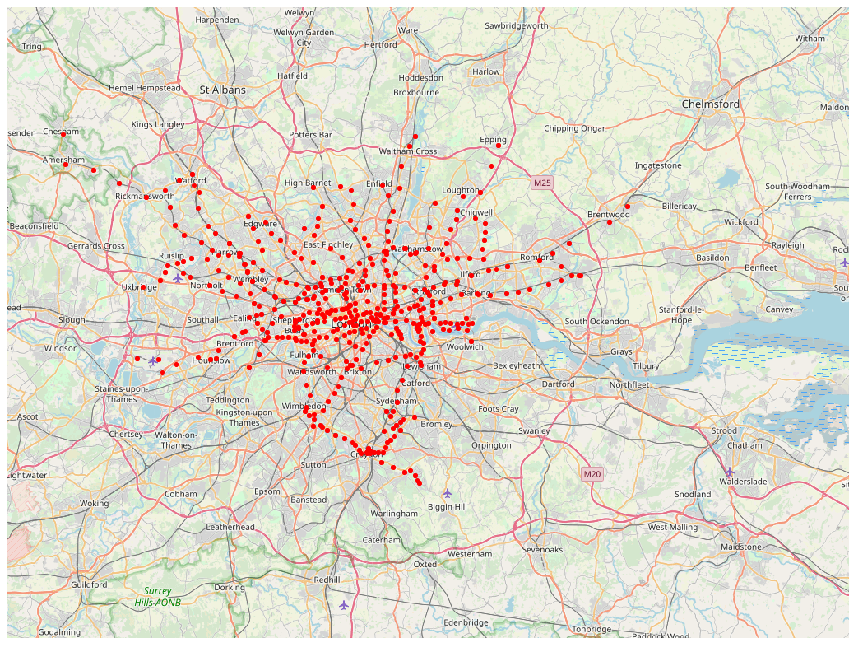

In [56]:
box_stations = (stations.y.min(), stations.x.min(),
       stations.y.max(), stations.x.max())
map = smopy.Map(box_stations, z=10) # z is the zoom level, here we set it as 10, you may want to try another value.
# map.show_ipython()
x, y = map.to_pixels(stations.y, stations.x)
ax = map.show_mpl(figsize=(12, 10))
ax.plot(x, y, 'or', ms=4, mew=1) # 'or' means red dots/circles

Next step is to set up our voronoi function for 2 dimensional points data as "voronoi_finite_polygons_2d".

In [18]:
# set up the voronoi function for our finite dataset

vor = Voronoi(np.c_[stations.y, stations.x])

def voronoi_finite_polygons_2d(vor, radius=None):
    """Reconstruct infinite Voronoi regions in a
    2D diagram to finite regions.
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()
    # Construct a map containing all ridges for a
    # given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points,
                                  vor.ridge_vertices):
        all_ridges.setdefault(
            p1, []).append((p2, v1, v2))
        all_ridges.setdefault(
            p2, []).append((p1, v1, v2))
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue
        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue
            # Compute the missing endpoint of an
            # infinite ridge
            t = vor.points[p2] - \
                vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal
            midpoint = vor.points[[p1, p2]]. \
                mean(axis=0)
            direction = np.sign(
                np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + \
                direction * radius
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        # Sort region counterclockwise.
        vs = np.asarray([new_vertices[v]
                         for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(
            vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[
            np.argsort(angles)]
        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices)

In [19]:
regions, vertices = voronoi_finite_polygons_2d(vor)   # call function

Get the results visualized as below:

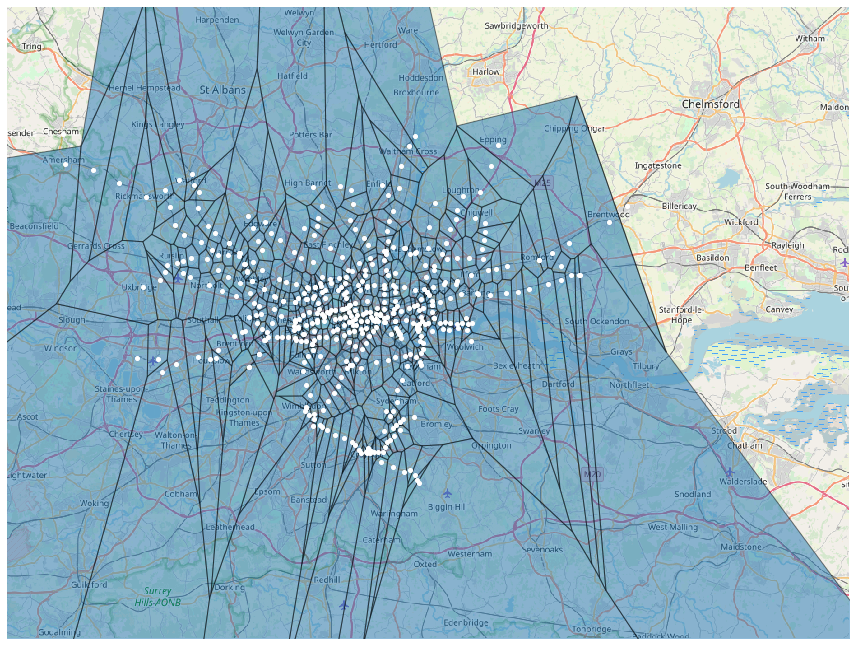

In [59]:
vor_stations = [map.to_pixels(vertices[region])
         for region in regions]  
ax = map.show_mpl(figsize=(12, 15)) # basemap definition
x, y = map.to_pixels(stations.y, stations.x) # plot the station points
ax.plot(x, y, 'ow', ms=4, mew=1) # white color and shape for points
ax.add_collection(mpl.collections.PolyCollection(vor_stations, edgecolors='k', alpha=.5)) # plot the voronoi

### <a id="Task 2">Task 2<a/>
Let's colorize Voronoi by defined bound, it will help to highlight voronoi differences by colors.

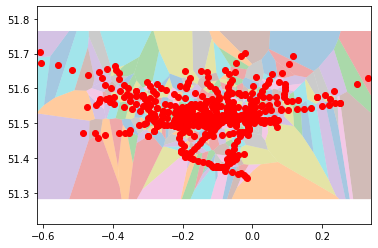

In [74]:
# compute Voronoi tesselation
vor = Voronoi(points)
# plot
regions, vertices = voronoi_finite_polygons_2d(vor)

min_x = vor.min_bound[0] - 0.06
max_x = vor.max_bound[0] + 0.06
min_y = vor.min_bound[1] - 0.06
max_y = vor.max_bound[1] + 0.06

mins = np.tile((min_x, min_y), (vertices.shape[0], 1))
bounded_vertices = np.max((vertices, mins), axis=0)
maxs = np.tile((max_x, max_y), (vertices.shape[0], 1))
bounded_vertices = np.min((bounded_vertices, maxs), axis=0)

bbox = Polygon([[min_x, min_y], [min_x, max_y], [max_x, max_y], [max_x, min_y]])

# colorize
for region in regions:
    polygon = vertices[region]
    # Clipping polygon
    poly = Polygon(polygon)
    poly = poly.intersection(bbox) # trim by bbox
    polygon = [p for p in poly.exterior.coords]

    plt.fill(*zip(*polygon), alpha=0.4) # `*` means unpack list

plt.plot(points[:, 0], points[:, 1], 'ro')
plt.axis('equal')
plt.xlim(vor.min_bound[0] - 0.01, vor.max_bound[0] + 0.01)
plt.ylim(vor.min_bound[1] - 0.01, vor.max_bound[1] + 0.01)

plt.show()
# if invisible, plt.savefig(a.png)

## <a id='Delaunay Triangulations'>Delaunay Triangulations</a> 

A [Delaunay Triangulations](http://mathworld.wolfram.com/DelaunayTriangulation.html) or [Delone Triangulations](https://en.wikipedia.org/wiki/Delaunay_triangulation) for a given set $P$ of discrete points in a plane, is a triangulation $DT(P)$, such that no point in $P$ is inside the circumcircle of any triangle in $DT(P)$. So there exists a unique Delaunay triangulation for $P$ if $P$ is a set of points in general position. To be brief, it is a subdivision of a set of points into a non-overlapping set of triangles, such that no point is inside the circumcircle of any triangle to avoid triangles with small angles. We can the compute the delaunay triangulations for London stations points through `SciPy` as follows. 

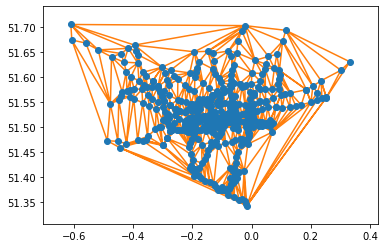

In [75]:
tri_stations = Delaunay(points)
_ = delaunay_plot_2d(tri_stations)
plt.show()

This could also get visualized through `matplotlib.triplot` as below:

Text(0, 0.5, 'Latitude')

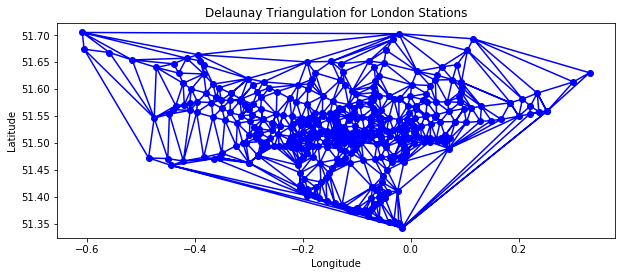

In [76]:
# Creating a Triangulation without specifying the triangles results in the
# Delaunay triangulation of the points.
x = stations['x']
y = stations['y']

# Create the Triangulation; no triangles so Delaunay triangulation created.
triang_stations = mpltri.Triangulation(x, y)

# Plot the triangulation.
plt.figure(figsize=(10,8))
plt.gca().set_aspect('equal')
plt.triplot(triang_stations, 'bo-') # define the color and shape
plt.title('Delaunay Triangulation for London Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

### Coplanar Points

[Coplanar Points](https://study.com/academy/lesson/what-are-coplanar-points-definition-examples.html) are three or more points that lie in the same plane (the flat surface), which extends without end in all directions. It is usually shown in math textbooks as a four-sided figure. It could be also derived from the `Delaunay Triangulations` function in `Scipy.spatial` as below.

In [77]:
tri_stations.coplanar

array([[389, 658, 390],
       [253, 859, 255]], dtype=int32)

The result should get an array with 3 numbers [$a$,$b$,$c$], but for our result it seems to be empty. Normally the first number $a$ is the index for point $a$, which is a duplicate/overlap point with others, and does not occur as a vertex of the triangulation $b$; and the third number $c$ is the nearest vertex for triangle $b$ to point $a$.

Now let us randomly pick up a station indexed with 10 for example, and do the following task:

In [78]:
i = 10
tri_stations.simplices[i,:] # the indices of the points that make up the triangle for point 10

array([ 9, 80, 84], dtype=int32)

In [79]:
points[tri_stations.simplices[i,:]] # coordinates of point 9, 80 and 84

array([[-0.60614676, 51.67366188],
       [-0.55915987, 51.66754646],
       [-0.60942108, 51.70474175]])

### <a id="Task 3">Task 3<a/>
1. Find the station names for above 3 points; **Hint**: recall your ability using index.
2. Get the information on neighboring triangles.

In [80]:
tri_stations.neighbors[i]  # indices for neighboring triangles

array([11, -1, 88], dtype=int32)

In [82]:
points[tri_stations.neighbors[i]] # coordinates for the other points in the neighboring triangles

array([[-0.06410424, 51.411617  ],
       [ 0.07049259, 51.48946942],
       [-0.26698161, 51.49415785]])

## <a id='Convex Hulls'>Convex Hulls<a/> (Optional)

As we are familiar with Convex hull (or Convex Envelope), it is the smallest convex object containing all points in a given point set $X$. Using our London stations data, let us compute convex hull via the [Qhull](http://www.qhull.org/) wrappers by either using a loop or calling the `convex_hall_plot_2d` method. Are they different significantly with each other?

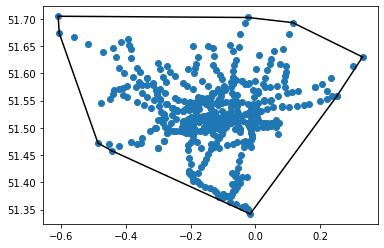

In [83]:
# use loop to plot convex hull
hull = ConvexHull(points)

plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.show()

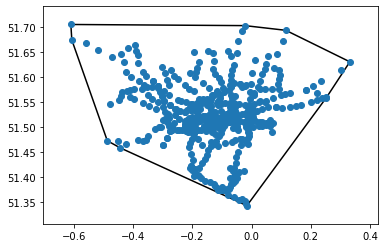

In [84]:
# use function to plot
_ = convex_hull_plot_2d(hull)
plt.show()

We could also have directly used the vertices of the hull, which for 2-D are guaranteed to be in counterclockwise order:

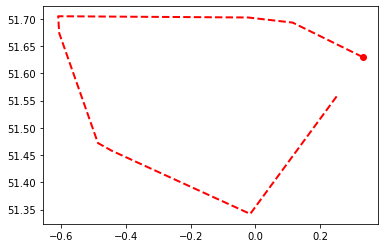

In [85]:
plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
plt.show()

### <a id="Task 4">Task 4</a>
1. Read the shapefile into a geodataframe "stations_gdf".
2. Save the stations .csv file into shapefile.
3. Reproject the shapefile into EPSG 27700, preparing for the distance calculation.
    
**Hint**: two essential libraries haven't been imported, you need to it by yourself here.

We use Geopandas's GeodataFrame to define the essential elements for geospatial data, i.e. **CRS**. A coordinate reference system (CRS) determines how the 2D coordinates of the geometry objects should be related to actual places on the earth, see [here](https://docs.qgis.org/2.8/en/docs/gentle_gis_introduction/coordinate_reference_systems.html) for further information. The essential definition of geometry depends on data type, and normally for point data, we will call `shapely.geometry.Point` to set up. **Hint**: Recall your skills on Week 3.

In [29]:
# your code here
import geopandas as gpd
from shapely.geometry.point import Point
# Set up geodataframe, initially with CRS = WGS84 (since that matches the lon and lat co-ordinates), recap on Week 3
crs = {'init':'epsg:4326'}
# define the geometry of points with coordinates
geometry = [Point(xy) for xy in zip(stations['x'], stations['y'])]

stations_gdf = gpd.GeoDataFrame(stations, 
                          crs = crs, 
                          geometry = geometry)
# convert the .csv file into .shp file 
stations_gdf.to_file(driver='ESRI Shapefile', filename='data/stations.shp')

# reprojection 
stations_gdf.to_crs(epsg=27700)

FID  OBJECTID               NAME  EASTING  NORTHING  \
0    291       477         Abbey Road   539077    183399   
1    258       162      Acton Central   520632    180296   
2    225       204         Acton Town   519478    179592   
3    455       421  Addington Village   537066    163744   
4    422       425         Addiscombe   534188    166297   
..   ...       ...                ...      ...       ...   
474  323        64           Woodford   540950    191740   
475  477       363    Woodgrange Park   541821    185350   
476  424       427           Woodside   534701    167101   
477  343       264      Woodside Park   525718    192588   
478  373       447   Woolwich Arsenal   543731    178811   

                    LINES             NETWORK  Zone         x          y  \
0                     NaN                 DLR     3  0.005308  51.531865   
1                     NaN   London Overground     3 -0.261566  51.508218   
2    District, Piccadilly  London Underground     3 -0.278433  51.502137   
3                     NaN            Tramlink     6 -0.031284  51.355710   
4                     NaN            Tramlink     5 -0.071626  51.379342   
..                    ...                 ...   ...       ...        ...   
474               Central  London Underground     4  0.035641  51.606360   
475                   NaN   London Overground     0  0.045631  51.548716   
476                   NaN            Tramlink     5 -0.063966  51.386453   
477              Northern  London Underground     4 -0.183907  51.617590   
478                   NaN                 DLR     4  0.070493  51.489469   

                          geometry  
0    POINT (539191.182 183345.370)  
1    POINT (520743.753 180242.117)  
2    POINT (519589.216 179538.188)  
3    POINT (537179.725 163687.793)  
4    POINT (534301.835 166241.053)  
..                             ...  
474  POINT (541064.331 191687.391)  
475  POINT (541935.437 185296.632)  
476  POINT (534813.992 167045.890)  
477  POINT (525830.889 192535.652)  
478  POINT (543845.530 178756.864)  

[479 rows x 11 columns]

## <a id="Buffering">Buffering<a/>

Buffers are one of the classical GIS operations, in that with a particular geometric object as the target, we define a specific radious/distance from its envelope, then a geometry is drawn around the target with an envelope at the defined distance. These are very useful, for instance, in combination with point-in-polygon operations to calculate accessibility, catchment areas, etc. In last practical, we had actually started to use the point-in-polygon operation when getting the heatmap for London pubs, through counting the number of pubs in each LSOA. Buffer could be taken one step further, on generating guard areas that can be added for a specified distance (or a range) around points, lines or polygons. Besides, buffers could play the role as basis for specific spatial operations, e.g. overlay, through calling `buffer` in `Shapely`, and we will further use it for next week. 

This week, we can use `geopandas` by simply calling the `buffer` method, passing it the the radius. Mind that the radius needs to be specified in the same units as the CRS of the geometry you are working with, hence we with generate 50 meters and 100 meters buffers respectively for each dataset to compare the effects from radius visually. Now let's try to produce buffers for **varied shapes** in City of London!

Buffers could be applied not only on **points** data, but also **polylines** and **polygons** data. So in this section, we will use the stations, railways and lsoas within the boundary of City of London as an example, to show you the buffering function for specified points, polylines and polygons. The data is directly accessible in CUSP London Github named as zipfile "city_ldn", and we will get you details about how to generate the data through spatial operation next week. So now please help yourself to download the data into your "data" folder by **either** way:

(1) Pay visit to https://github.com/cusp-london/Spatial-Data-Analysis/blob/master/city_ldn.zip, download the zipfile to your local directory and unzip it.

(2) Write your code on downloading data from Github. **Hint**: This has been covered on Week 3's practical.
### <a id="Task 5">Task 5<a/>
1. Download the dataset for City of London into your "data" folder for this week; 
2. Read three shapefile data into geodataframe respectively as: stations_city_ldn, railways_city_ldn, and lsoas_city_ldn.

In [89]:
# If you choose to get the data by solution (2)
# complete this code block

# Configure the download
url  = 'https://github.com/cusp-london/Spatial-Data-Analysis/blob/master/city_ldn.zip?raw=true'
path = os.path.join("data","city_ldn.zip")

# Download
r    = urllib.request.urlretrieve(url, path)

# Unzip it into the data folder
z    = zipfile.ZipFile(path)
m    = z.extractall('data')

In [21]:
stations_city_ldn=gpd.read_file('data/city_ldn/stations_city_ldn.shp')
railways_city_ldn=gpd.read_file('data/city_ldn/railways_city_ldn.shp')
lsoas_city_ldn=gpd.read_file('data/city_ldn/city_ldn.shp')

Let us firstly get a 50 metres buffer around each station in City of London, and then 100 metres buffer.

In [22]:
buf_50_s = stations_city_ldn.buffer(50)
buf_100_s = stations_city_ldn.buffer(100)

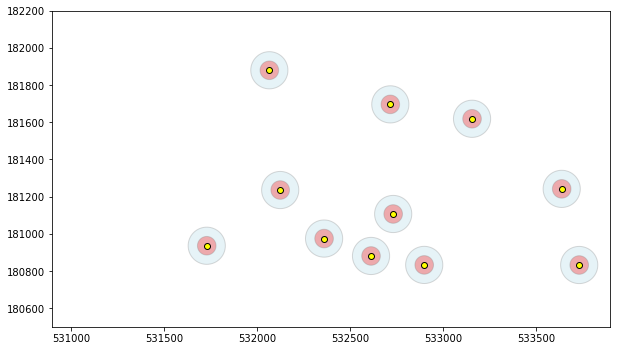

In [23]:
plt.rcParams['figure.figsize'] = (10, 8)
ax = plt.gca()
buf_100_s.plot(ax=ax,color='lightblue', edgecolor='grey', alpha=0.3)
buf_50_s.plot(ax=ax,color='red', edgecolor='grey', alpha=0.3)
stations_city_ldn.plot(ax=ax, color='yellow', edgecolor='k')
ax.set_xlim(530900, 533900); ax.set_ylim(180500, 182200) # specify the bbox of axis for city of london
ax.set_aspect('equal')
plt.show()

The buffering operation for polyline, railways in city of london, is similar to what we've done to points data, so let's try to complete task 6.
### <a id="Task 6">Task 6<a/>
1. Create 50 meters and 100 meters buffers for railways in City of London respectively;
2. Plot them below following the similar methods as above.

In [25]:
buf_50_r = railways_city_ldn.buffer(50)
buf_100_r = railways_city_ldn.buffer(100)

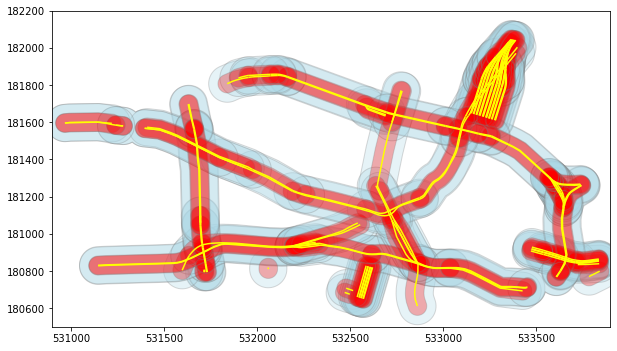

In [94]:
# plot your buffered railways
plt.rcParams['figure.figsize'] = (10, 8)
ax = plt.gca()
buf_100_r.plot(ax=ax,color='lightblue', edgecolor='grey', alpha=0.3)
buf_50_r.plot(ax=ax,color='red', edgecolor='grey', alpha=0.3)
railways_city_ldn.plot(ax=ax, color='yellow', edgecolor='k')
ax.set_xlim(530900, 533900); ax.set_ylim(180500, 182200) # specify the bbox of axis for city of london
ax.set_aspect('equal')
plt.show()

In [24]:
# buffer for lsoas
buf_50_c=lsoas_city_ldn.buffer(50)
buf_100_c=lsoas_city_ldn.buffer(100)

ax = plt.gca()
buf_100_c.plot(ax=ax,color='lightblue', edgecolor='grey', alpha=0.2)
buf_50_c.plot(ax=ax,color='red', edgecolor='grey', alpha=0.2)
lsoas_city_ldn.plot(ax=ax, color='white', edgecolor='k')
ax.set_xlim(530800, 534000); ax.set_ylim(180300, 182500)
ax.set_aspect('equal')
plt.show()

Discuss with your neighbors: How if we choose a negative buffer distance? What will happen to the geometry? How about a zero buffer then? Have your codes here:

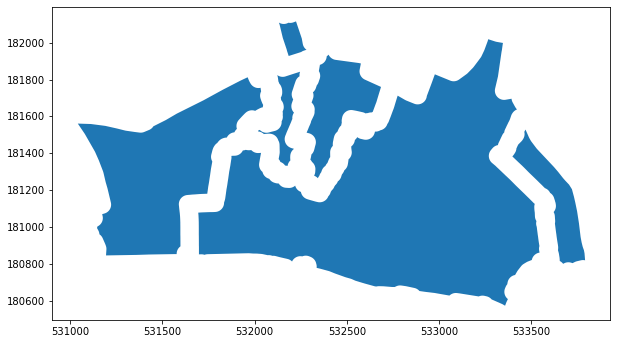

In [96]:
buf_neg50_c=lsoas_city_ldn.buffer(-50)
buf_neg50_c.plot()

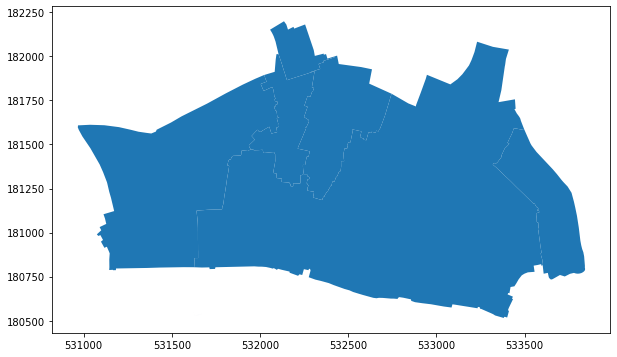

In [97]:
buf_zero_c=lsoas_city_ldn.buffer(0)
buf_zero_c.plot()

If you want to read the ballpark boundary of buffers, for example the 100 meters' buffers for varied shapes, you may call `Bounding Box` to make the smallest possible rectangle that completely encloses your buffered area. The output could be just a tuple of the "minx", "miny", "maxx", "maxy".

In [26]:
buf_s_bb=buf_100_s.bounds
buf_r_bb=buf_100_r.bounds
buf_c_bb=buf_100_c.bounds
print(buf_s_bb, buf_r_bb, buf_c_bb)

minx           miny           maxx           maxy
0   533537.930173  181141.531008  533737.930173  181341.531008
1   532631.900061  181006.506100  532831.900061  181206.506100
2   531966.088380  181779.235391  532166.088380  181979.235391
3   531629.550660  180835.763829  531829.550660  181035.763829
4   532512.808821  180780.839624  532712.808821  180980.839624
5   533055.917396  181518.355281  533255.917396  181718.355281
6   532260.401928  180874.410351  532460.401928  181074.410351
7   532798.757417  180732.669578  532998.757417  180932.669578
8   532616.505764  181595.882000  532816.505764  181795.882000
9   532024.483718  181135.339282  532224.483718  181335.339282
10  533632.018165  180732.271204  533832.018165  180932.271204               minx           miny           maxx           maxy
0    533093.729312  181626.887466  533492.099717  182070.553163
1    533083.950972  181634.591681  533499.727252  182102.921284
2    532597.195690  181481.297305  533114.293501  181754.624579
3

## [Interpolation](https://en.wikipedia.org/wiki/Multivariate_interpolation)

Interpolation is a method of constructing new data points within the range of a discrete set of known data points. There are various methods to realize interpolation, e.g. Piecewise constant interpolation, Linear interpolation, Polynomial interpolation, Spline interpolation, Inverse Distance Weighting interpolation etc. To be brief, we normally start with known values, and want to estimate the unknown points through interpolation.
It is straightforward to do so with `numpy`, `scipy.interpolate.griddata`, and `matplotlib`. However, we will not spend too much time on the normal interpolation functions this time, instead we will try to visualize a more sophisticated and widely utilized interpolation, kriging, by calling `pykrige` in this practical.

The basic rationale for `scipy`'s `griddata` interpolation is that:

$x$ and $y$ are locations of points, corresponding to longitude and latitude values of the stations; we need another $z$ value for the corresponding point, so we will read in a new dataset "annual station entry and exit figures" to measure the stations performances (by million, and compiled based on data from London Datastore).

The defined interpolation method will work out a way to mask the field, upon the user's defintion of a landmask on the grid, it will further try to calculate the result for the target grid axes. $x_i$ and $y_i$ are target grid axes, in another word, the target longitude and latitude coordinates, which must match the landmask field; whilst $z_i$ is the interpolated result for the point value. The methods argument to griddata could be various, either linear, cubic or nearest. 

Let's firstly join the 2 datasets together.

In [99]:
# Configure the download
url  = 'https://github.com/cusp-london/Spatial-Data-Analysis/blob/master/Entry2018.csv?raw=true'
path = os.path.join("data","Entry2018.csv")

# Download
r    = urllib.request.urlretrieve(url, path)

In [28]:
ee_stations=pd.read_csv('data/Entry2018.csv')
ee_stations.info

<bound method DataFrame.info of          Station Name  Entry_MTT  Entry_FRI
0          Abbey Road       2114       2185
1       Acton Central       3728       3891
2     Acton Main Line        776        801
3          Acton Town       9889      10337
4             Aldgate      17014      15554
..                ...        ...        ...
412       Wood Street       3862       3853
413          Woodford       9889       9915
414   Woodgrange Park       1488       1494
415     Woodside Park       6076       6249
416  Woolwich Arsenal      28768      29011

[417 rows x 3 columns]>

You may find 417 stations in this dataset, which is not consistent with the London station locational data. As this updated dataset: (1) use the combined entry data for some stations, like Bank & Monument; (2) has some new stations, like Hayes & Harllington added; (3) include overground, TfL train etc.


Because not all stations have values on entries, so we need to add the information from **ee_stations** dataframe.
### <a id="Task 7">Task 7<a/>
1. join these two datasets by station names;
2. delete those rows with NaN values;
3. only keep columns 'name', 'latitude', 'longitude', 'Entry_MTT' and 'Entry_FRI' for further interpolation operations.

In [101]:
# Your code here
sta_ee=ee_stations.join(stations.set_index('NAME'), on='Station Name').dropna()
sta_ee.drop(columns=['FID', 'OBJECTID','NETWORK'])

Station Name  Entry_MTT  Entry_FRI   EASTING  NORTHING  \
3        Acton Town       9889      10337  519478.0  179592.0   
4           Aldgate      17014      15554  533613.0  181262.0   
5      Aldgate East      23843      25167  533936.0  181375.0   
7          Alperton       4597       4574  517996.0  183795.0   
8          Amersham       3890       3651  496372.0  198181.0   
..              ...        ...        ...       ...       ...   
409  Wimbledon Park       4161       4215  525282.0  172100.0   
410      Wood Green      18866      20492  531015.0  190428.0   
411       Wood Lane       8169       8482  523374.0  180519.0   
413        Woodford       9889       9915  540950.0  191740.0   
415   Woodside Park       6076       6249  525718.0  192588.0   

                            LINES  Zone         x          y  \
3            District, Piccadilly   3.0 -0.278433  51.502137   
4            Metropolitan, Circle   1.0 -0.074236  51.513982   
5    Hammersmith & City, District   1.0 -0.069540  51.514917   
7                      Piccadilly   4.0 -0.298361  51.540227   
8                    Metropolitan   9.0 -0.606147  51.673662   
..                            ...   ...       ...        ...   
409                      District   3.0 -0.197491  51.433537   
410                    Piccadilly   3.0 -0.108247  51.596971   
411    Hammersmith & City, Circle   2.0 -0.221994  51.509632   
413                       Central   4.0  0.035641  51.606360   
415                      Northern   4.0 -0.183907  51.617590   

                      geometry  
3    POINT (-0.27843 51.50214)  
4    POINT (-0.07424 51.51398)  
5    POINT (-0.06954 51.51492)  
7    POINT (-0.29836 51.54023)  
8    POINT (-0.60615 51.67366)  
..                         ...  
409  POINT (-0.19749 51.43354)  
410  POINT (-0.10825 51.59697)  
411  POINT (-0.22199 51.50963)  
413   POINT (0.03564 51.60636)  
415  POINT (-0.18391 51.61759)  

[275 rows x 10 columns]

Text(0.5, 1.0, 'entries in 2018')

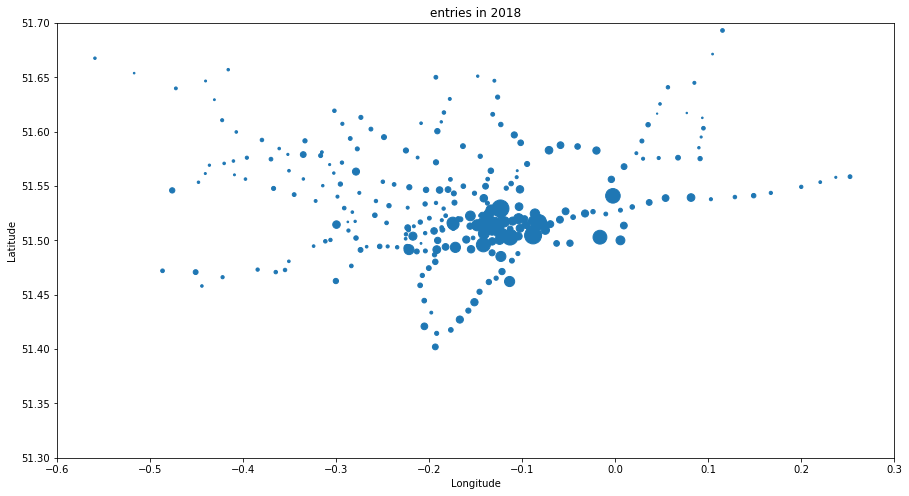

In [102]:
x=sta_ee['x']
y=sta_ee['y']
z=sta_ee['Entry_MTT']/500
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(x,y,z, cmap='grey')
# ax.set_aspect(1)
ax.set_xlim(-0.6,0.3)
ax.set_ylim(51.3,51.7)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('entries in 2018')

### <a id='Basic Interpolation'>Basic Interpolation</a>
As we only get the entries values for 275 stations, so how shall we estimate the entries for other stations specifically? For example, All Saints station at (51.5107, -0.013) and Blackwall station at (51.5079, -0.0066). We can use interpolation technique to realize it. Let's start from basic statistical interpolation: 

Text(0.5, 1.0, '')

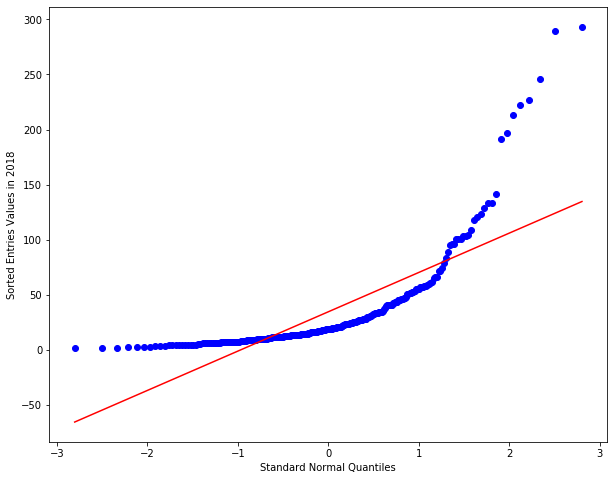

In [103]:
import scipy.stats as stats
qqdata = stats.probplot(z, dist="norm",plot=plt,fit=False)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.xlabel('Standard Normal Quantiles')
plt.ylabel('Sorted Entries Values in 2018')
plt.title('')

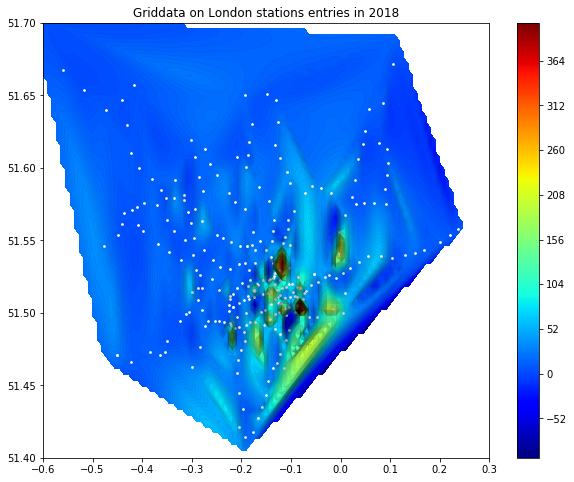

In [104]:
from scipy.interpolate import griddata
import numpy.ma as ma

lons=sta_ee['x']
lats=sta_ee['y']

# define grid with 0.009°longitude and 0.004°latitude steps.
xi = np.linspace(-0.6,0.3,100)
yi = np.linspace(51.3,51.7,100)
# grid the data, methods might be cubic, linear and nearest
zi = griddata((lons, lats), z, (xi[None,:], yi[:,None]), method='cubic') 
# contour the gridded data, plotting dots at the randomly spaced data points.
CS = plt.contour(xi,yi,zi,255,linewidths=0.05,colors='k')
CS = plt.contourf(xi,yi,zi,255,cmap=plt.cm.jet)
plt.colorbar() # draw colorbar
# plot data points.
plt.scatter(lons,lats,marker='o',c='w',s=3)
plt.xlim(-0.6,0.3)
plt.ylim(51.4,51.7)
plt.title('Griddata on London stations entries in 2018')
plt.show()

### [<a id='Kriging Interpolation'>Kriging Interpolation</a>](https://en.wikipedia.org/wiki/Kriging)
`Kriging` is a set of geostatistical techniques for interpolation, based on statistical models that include `spatial autocorrelation` (will be covered on week 8), or tendency of values of entities closer in space to be related. Differs from other interpolation techniques, Kriging honors those measurements at sampled locations, and instead sacrifices smoothness for the integrity of sampled points; so it can either provide an optimal continuous prediction surface or map of the phenomenon, or deliver a measure of confidence of how likely that prediction will be true. For example, if we want to interpolate the rainfall value for specific location in London, kriging can not only tell us how much the rainfall there, but also the probability of such volumn of rainfall. 

Kriging is widely used in the domain of spatial analysis and computer experiments, and is most appropriate when you know there is a spatially correlated distance or directional bias in the data. It is more predictive for probability rather than deterministic. Under suitable assumptions on the prior covariances, kriging gives the best linear unbiased prediction of the intermediate values using Gaussian process model: Z(s) = μ(s) + ε(s), where μ(s) is the deterministic component and ε(s) is the probabilistic component, and both are functions of distance. In order to predict the values at unmeasured locations, the weights were formed from surrounding measured values and their spatial structures, which was the crucial component for Kriging interpolation `semivariogram`. 

Semivariogram plots the difference in pair values (variance) against their distances, closer things are more related and have small semivariance (SV), while far things are less related and have a high semivariance (SV) until certain distance (range), reaching at a flattened value (sill) and the intercept (nugget), indicating no longer any spatial autocorrelation. Based on these results, we can further select a semivariogram that is spherical, circular, exponential, Gaussian or linear. 

Practically Kriging is a multistep process including exploratory statistical analysis of the data, variogram modeling, creating the surface, and exploring a variance surface. So we will, in the following, start with building a mathematical function with a `semivariogram`, then to create a prediction surface and finally validate the model with cross-validation.  

Let's start our visualization with simpler 1-dimensional Kriging interpolation for London station data. 

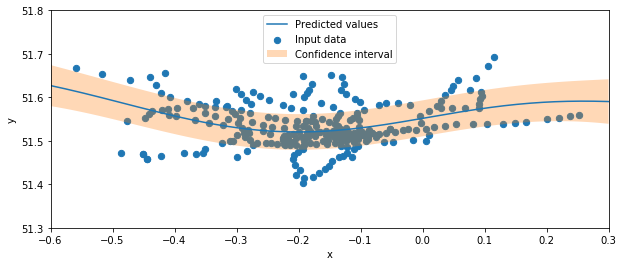

In [105]:
import os
X = np.asarray(lons).T
y = np.asarray(lats).T
X_pred = np.linspace(-0.6, 0.3, 300)
# pykrige doesn't support 1D data for now, only 2D or 3D
# adapting the 1D input to 2D
uk = OrdinaryKriging(X, np.zeros(X.shape), y, variogram_model='gaussian',)
y_pred, y_std = uk.execute('grid', X_pred, np.array([0.]))
y_pred = np.squeeze(y_pred)
y_std = np.squeeze(y_std)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.scatter(X, y, s=40, label='Input data')
ax.plot(X_pred, y_pred, label='Predicted values')
ax.fill_between(X_pred, y_pred - 20*y_std, y_pred + 20*y_std, alpha=0.3, label='Confidence interval') 
# change the value of the confidence interval, any differences spotted?
ax.legend(loc=9) 
ax.set_xlabel('x') 
ax.set_ylabel('y') 
ax.set_xlim(-0.6, 0.3) 
ax.set_ylim(51.3, 51.8)
if 'CI' not in os.environ:
    # skip in continous integration
    plt.show()

#### <a id='2D Kriging Calculation'>2D Kriging Calculation</a> 
A brief idea about the predicative capability of Kriging interpolation could be derived from you work above, and now let's move further to 2-dimensional data.

#### Choose the Kriging Type
It is one of the essential criteria to choose types for kriging. As in widely used geographical appliciations, e.g. ArcGIS 10.x, the defaulted methods for kriging are either `Ordinary kriging` or `Simple Kriging`, we are going to practice with `Ordinary kriging`. However, it is better to have knowledge that, there are more complicated kriging types exist:
- Universal Kriging: combines trend surface analysis (drift) with ordinary kriging by accounting for trends
- Indicator Kriging: carries through ordinary kriging with binary data (0 and 1) such as urban and non-urban cells.
- Probablity Kriging: uses binary data (similar to indicator kriging) and estimates unknown points for a series of cutoffs.

**Semivariogram** is crucial to Kriging interpolation, with essential outputs for interpreting the Kriging interpolation calculation.

The semivariogram allows us to show the average variation for each pair of points, and is given by,
<img src="3.png" style="width: 200px;"/>

where $h$ is distance specified by the user, and $z_i$ and $z_j$ are two points that are separated spatially by h. The $N(h)$ term is the number of points we have that are separated by the distance h. The semivariogram then is the sum of squared differences between values separated by a distance $h$,
<img src="4.png" style="width: 200px;"/>


where $N$ is the number of data points, $\hat\mu$ is the sample mean, and $z_k$ is a data point. For sample variance, we are taking the squared difference between data points and the mean, and in the semivariogram we are taking the squared difference between data points separated by distance $h$, and the inverse is the covariance matrix which shows correlation over space. Based on the scatter of points, the computer fits a curve through those points with a slope where autocorrelation exists.
<img src="Variogram.png" style="width: 200px;"/>
**Sill**: The value at which the model first flattens out.

**Range**: The distance at which the model first flattens out.

**Nugget**: The value at which the semi-variogram (almost) intercepts the y-value.

We use the `ordinary kriging` function of `pykrige` package to interpolate our data at the defined grid points. For more details, the user can refer to the manual of the `pykrige` package.

In [106]:
# geometric ordinary kriging on a sphere
# Make this example reproducible:
np.random.seed(1234567)

N=275
lons=np.asarray(sta_ee['x']).T
lats=np.asarray(sta_ee['y']).T
z=np.asarray(sta_ee['Entry_MTT']).T
# Generate a regular grid with 0.009°longitude and 0.004°latitude 100 steps:
# change the value of steps and spot out the differences of outputs:
grid_lons = np.linspace(-0.6, 0.3, 101)
grid_lats = np.linspace(51.3, 51.7, 101)
# Create ordinary kriging object:
OK = OrdinaryKriging(lons, lats, z, variogram_model='linear', verbose=False,
                     enable_plotting=False, coordinates_type='geographic')
# Execute on grid:
z1, ss1 = OK.execute('grid', grid_lons, grid_lats)

# Create ordinary kriging object ignoring curvature:
OK = OrdinaryKriging(lons, lats, z, variogram_model='linear', verbose=False,
                     enable_plotting=False)
# Execute on grid:
z2, ss2 = OK.execute('grid', grid_lons, grid_lats)
# Print data at equator (last longitude index will show periodicity):
print("Original data:") 
print("Longitude:",lons.astype(float))
print("Latitude: ",lats.astype(float))
print("z: ",z.astype(float)) 
print("\n======================\nKrige at\nLatitude:", grid_lats) 
print("Longitude:",grid_lons)
print("Value: ",np.array_str(z1[5,:], precision=2)) 
print("Sigma2: ",np.array_str(ss1[5,:], precision=2)) 
print("\nIgnoring curvature:\n=====================") 
print("Value: ",np.array_str(z2[5,:], precision=2)) 
print("Sigma2: ",np.array_str(ss2[5,:], precision=2))

Original data:
Longitude: [-0.27843282 -0.0742363  -0.0695404  -0.29836113 -0.60614676 -0.10311636
 -0.13344404 -0.13143482 -0.1056744  -0.15545439 -0.15109021 -0.09718967
  0.08181355  0.09025955 -0.21308817 -0.1863227   0.12897864 -0.16301696
 -0.06274589 -0.0530747  -0.0530747  -0.10202025 -0.04017434 -0.14807688
 -0.09170282 -0.32401176 -0.12273102 -0.02358427 -0.21218525 -0.11328884
 -0.00984104  0.04845534 -0.26239884 -0.11686426 -0.14101689 -0.04837224
 -0.01613482  0.00956888 -0.08880104 -0.29310256 -0.55915987 -0.15103702
 -0.10996055 -0.12577717 -0.60942108  0.07722917 -0.26698161 -0.51698518
 -0.13558899 -0.12775437 -0.14561037 -0.14755319 -0.24834191 -0.17646089
 -0.12275994 -0.44019171  0.16761746  0.14915838  0.08540318 -0.23744515
 -0.2994185  -0.28655548 -0.19157701 -0.24556927 -0.16343863  0.05445491
 -0.20946866 -0.39578946 -0.27318371 -0.16864595 -0.16617074  0.20031156
 -0.12056243  0.11564137 -0.13299207 -0.13299207 -0.13427058  0.09268813
 -0.10358241 -0.19095192 

We can see that the interpolated value 17161.61 dominates the kriged results, since it is the closest node in spherical distance metric, as longitude differences scale with cos(latitude). When kriging using longitude / latitude linearly, the value for grid points with longitude values further away, as longitude is now incorrectly weighted equally as latitude. So let's try to change the `variogram_model` method into `gaussian`, and see what's the difference. This time, we also further changed the values for minimum and maximum of the longitude and latitude based on the data.

Plotting Enabled

Initializing variogram model...
Coordinates type: 'geographic' 

Using 'gaussian' Variogram Model
Partial Sill: 418473502.85686874
Full Sill: 422881155.45419186
Range: 1.3460964981559798e-08
Nugget: 4407652.597323106 



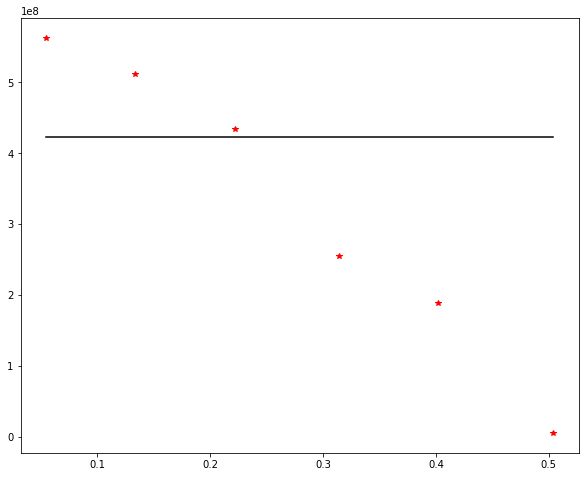

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In [107]:
# change the variogram_model method into gaussian, results varied, optimal methods
grid_lon = np.arange(lons.min()-0.001, lons.max()+0.001, 200) # define the grid points for interpolated values.
grid_lat = np.arange(lats.min()-0.001, lats.max()+0.001, 200)

# Creates the kriged grid and the variance grid. Allows for kriging on a rectangular 
OK = OrdinaryKriging(lons, lats, z, variogram_model='gaussian', verbose=True, enable_plotting=True, coordinates_type='geographic')
# grid of points, on a masked rectangular grid of points, or with arbitrary points. 
z1, ss1 = OK.execute('grid', grid_lon, grid_lat)

As we only have 275 stations joined, and want to predict the entry & exit figure for other excluded stations, e.g. All Saints station at (51.5107, -0.013) and Blackwall station at (51.5079, -0.0066), so we can use `Ordinary Kriging` to interpolate the missing data.

In [108]:
ztest, sstest = OK.execute('grid', [-0.013, -0.00066], [51.5107, 51.5079])
print(ztest)

Executing Ordinary Kriging...

[[16766.641027167196 16766.641027167196]
 [16766.641027167196 16766.641027167196]]


#### <a id='2D Kriging Visualization'>2D Kriging Visualization</a> 
To get interpolation results plotted will be more straightforward, but we should be careful about the geographical data's CRS when conducting any spatial analysis.

In [35]:
# save sta_ee into shapefile
crs={'init': 'epsg:4326'}
# define the geometry of points with coordinates
geometry = [shapely.geometry.Point(xy) for xy in zip(sta_ee['x'], stat_ee['y'])]

data_df = gpd.GeoDataFrame(sta_ee, 
                          crs = crs, 
                          geometry = geometry)
# convert the .csv file into .shp file 
data_df.to_file(driver='ESRI Shapefile', filename='data/sta_ee.shp')

### <a id="Task 8">Task 8<a/>
Get London stations plotted with `folium` below, and we will try to compare it with the kriging interpolation plot at the end.

In [31]:
# call the original dataframe
# plot latitude and longitude with WGS84 on folium
data_lat_long=gpd.read_file('data/sta_ee.shp')
data_lat_long['long'] = data_lat_long.geometry.apply(lambda x: x.x)
data_lat_long['lat'] = data_lat_long.geometry.apply(lambda x: x.y)
# mean value for longitude and latitude, kinds of centroid point
mean_long = np.mean(data_lat_long['long'] )
mean_lat = np.mean(data_lat_long['lat'] )

m = folium.Map([mean_lat, mean_long], zoom_start=10, tiles='Stamen Toner')

scale = cm.linear.YlGn_06.scale(vmin=0, vmax=data_lat_long['Entry_MTT'].max())  

# plot the circle markers
for row in data_lat_long.iterrows():
    folium.CircleMarker(location=[row[1]['lat'], row[1]['long']], radius=10, color=None, fill_opacity=0.7,
                    fill_color=scale(row[1]['Entry_MTT'])).add_to(m)
m.add_children(scale)

Be careful now! We have the "data_lat_long" dataframe with WGS84 coordinates, this will be used for interactive map visualization using `folium`, and will only be used at the end of this practical hereafter. However, since now we need to use another dataframe "staee" with OSBG 1936 (EPSG 27700) for following operations, or simply use **EASTING** and **NORTHING** columns. why bother to do so? Try to discuss the reasons with your neighbors. **Hint**: recall your memory of last week. 

In [33]:
staee=gpd.read_file('data/sta_ee.shp')

#### 1. Split the data into test and train

The process is similar to what we did with K Nearest Neighbors Classification, we set the dataset into train set and test set, to evaluate the interpolation results. As the basic rationale is distance-based, we need to use EPSG 27700 for calculation.

In [34]:
np.random.seed(9999999) # Control the random split with setting a seed so the results are reproducable
 # split the data into train and test by calling len
test_indexes = np.random.choice(a=staee.index, size=int(np.round(len(staee.index.values)/5)))
train_indexes = [index for index in staee.index if index not in test_indexes]
staee_test = staee.loc[test_indexes,:].copy()
staee_train = staee.loc[train_indexes,:].copy()
print('Number of observations in training: {}, in test: {}'.format(len(staee_train), len(staee_test)))

Number of observations in training: 226, in test: 55


#### 2. Ordinary kriging

Variogram parameters are set with trail and error.

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 995000000
Full Sill: 1000000000
Range: 20000
Nugget: 5000000 



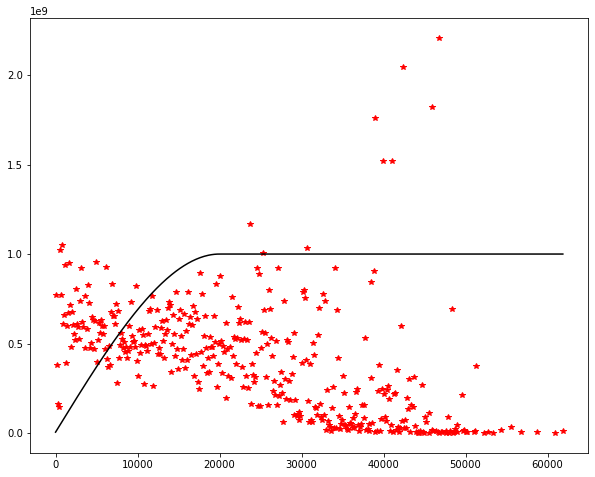

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Executing Ordinary Kriging...



In [117]:
# choose the sill，range and nugget by variogram_parameters configuration
model = OrdinaryKriging(x=staee_train['EASTING'], y=staee_train['NORTHING'], z=staee_train['Entry_MTT'], verbose=True,
                variogram_parameters=[1000000000, 20000, 5000000],
                enable_plotting=True, nlags=500, weight=True, variogram_model='spherical')
staee_train['prediction'] = model.execute(style='points',xpoints=staee_train['EASTING'], ypoints=staee_train['NORTHING'])[0].data
staee_train['kriging_residual'] = staee_train['Entry_MTT'] - staee_train['prediction']
staee_test['prediction'] = model.execute(style='points', xpoints=staee_test['EASTING'], ypoints=staee_test['NORTHING'])[0].data
staee_test['kriging_residual'] = staee_test['Entry_MTT'] - staee_test['prediction']

#### Model performance (Optional)

We can test the model performance by plotting out some measures on:
- Performance on training data (kriging is an exact interpollator, so perfect prediction)
- Performance on test data

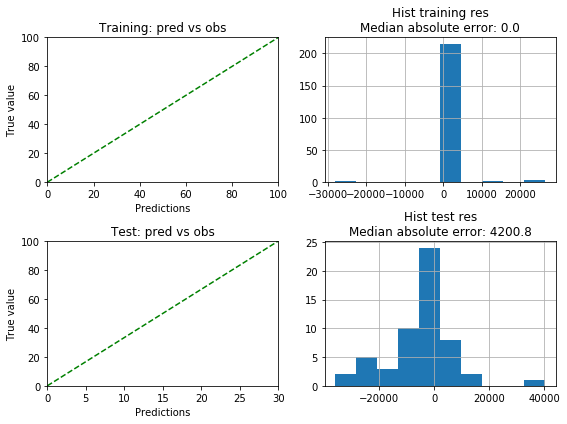

In [118]:
plt.figure(figsize=(8,6))
plt.subplot(221)
plt.plot(staee_train['prediction'], staee_train['Entry_MTT'], '.')
plt.title('Training: pred vs obs')
plt.xlabel('Predictions')
plt.ylabel('True value')
plt.plot([0,100], [0,100], 'g--')
plt.ylim(0,100)
plt.xlim(0,100)

plt.subplot(222)
staee_train['kriging_residual'].hist()
plt.title('Hist training res\nMedian absolute error: {:.1f}'.format(np.median(np.abs(staee_train['kriging_residual']))))

plt.subplot(223)
plt.plot(staee_test['prediction'], staee_test['Entry_MTT'], '.')
plt.plot([0,30], [0,100], 'g--')
plt.title('Test: pred vs obs')
plt.xlabel('Predictions')
plt.ylabel('True value')
plt.ylim(0,100)
plt.xlim(0,30)

plt.subplot(224)
staee_test['kriging_residual'].hist()
plt.title('Hist test res\nMedian absolute error: {:.1f}'.format(np.median(np.abs(staee_test['kriging_residual']))))
plt.tight_layout()

#### 3. Sample grids
The training data are sampled from the plotted grids, which are polygon, this is quite similar idea to what we did at the begining, `Voronoi`; so if we want to know how the grids been drawn, and how the points have been sampled from the grid polygon, we need to recall the concept of `convex hull` around the measurement, the method of `buffering` just introduced, and get the functions to sample a grid from a polygon. Although I list the functions below, but you can further read the [help document](http://portolan.leaffan.net/creating-sample-points-with-ogr-and-shapely-pt-2-regular-grid-sampling/).

In [119]:
class PolygonPointSampler(object):
 
    def __init__(self, polygon=''):
        u"""
        Initialize a new PolygonPointSampler object using the specified polygon
        object (as allocated by Shapely). If no polygon is given a new empty
        one is created and set as the base polygon.
        """
        if polygon:
            self.polygon = polygon
        else:
            self.polygon = Polygon()
        self.samples = list()
        self.sample_count = 0
        self.prepared = False
 
    def add_polygon(self, polygon):
        u"""
        Add another polygon entity to the base polygon by geometrically unifying
        it with the current one.
        """
        self.polygon = self.polygon.union(polygon)
        self.prepared = False
    
    def get_spatial_df(self):
        geo_df = pd.DataFrame(self.samples, columns=['geometry']).set_geometry('geometry')
        geo_df['x'] = geo_df['geometry'].apply(lambda x: x.coords[0][0])
        geo_df['y'] = geo_df['geometry'].apply(lambda x: x.coords[0][1])
        return geo_df
 
    def print_samples(self):
        u"""
        Print all sample points using their WKT representation.
        """
        for sample_pt in self.samples:
            print(sample_pt)
 
    def prepare_sampling(self):
        u"""
        Prepare the actual sampling procedure by splitting up the specified base
        polygon (that may consist of multiple simple polygons) and appending its
        compartments to a dedicated list.
        """
        self.src = list()
        if hasattr(self.polygon, 'geoms'):
            for py in self.polygon:
                self.src.append(py)
        else:
            self.src.append(self.polygon)
        self.prepared = True
 
    def perform_sampling(self):
        u"""
        Create a stub for the actual sampling procedure.
        """
        raise NotImplementedError
    
class RegularGridSampler(PolygonPointSampler):
    def __init__(self, polygon = '', x_interval = 100, y_interval = 100):
        super(self.__class__, self).__init__(polygon)
        self.x_interval = x_interval
        self.y_interval = y_interval
    
    def perform_sampling(self):
        u"""
        Perform sampling by substituting the polygon with a regular grid of
        sample points within it. The distance between the sample points is
        given by x_interval and y_interval.
        """
        if not self.prepared:
            self.prepare_sampling()
        ll = self.polygon.bounds[:2]
        ur = self.polygon.bounds[2:]
        low_x = int(ll[0]) / self.x_interval * self.x_interval
        upp_x = int(ur[0]) / self.x_interval * self.x_interval + self.x_interval
        low_y = int(ll[1]) / self.y_interval * self.y_interval
        upp_y = int(ur[1]) / self.y_interval * self.y_interval + self.y_interval
        
        for x in floatrange(low_x, upp_x, self.x_interval):
            for y in floatrange(low_y, upp_y, self.y_interval):
                p = shapely.geometry.Point(x, y)
                if p.within(self.polygon):
                    self.samples.append(p)

def floatrange(start, stop, step):
    while start < stop:
        yield start
        start += step

Be careful now! Here we need to check the geometry for **staee** geodataframe with WGS84 coordinates, we need it to be with OSBG 1936 (EPSG 27700) for following operations, why bother to do so? Try to discuss the reasons with your neighbors. **Hint**: recall your memory of last week. 

In [120]:
staee=data_df.to_crs({'init': 'epsg:27700'})# change the crs into OSGB36 for further distance measurement
staee['x'] = staee['geometry'].apply(lambda x: x.x)
staee['y'] = staee['geometry'].apply(lambda x: x.y)

Text(0.5, 1.0, 'Sampled grid')

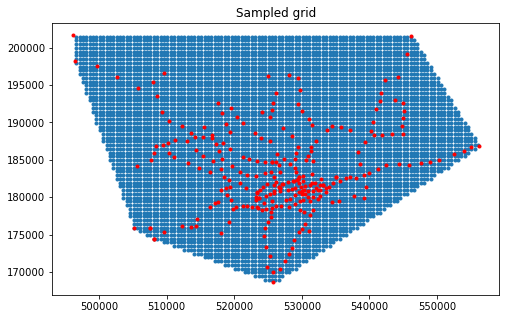

In [121]:
convex_hull = shapely.geometry.MultiPoint(list(staee.geometry)).convex_hull.buffer(100)
sampler = RegularGridSampler(convex_hull, x_interval=500, y_interval=500) # what is the unit of value 500?
sampler.perform_sampling()
grid_points = sampler.get_spatial_df()
plt.figure(figsize=(8,5))
plt.plot(grid_points['x'], grid_points['y'], '.')
plt.plot(staee['EASTING'], staee['NORTHING'], 'r.')
plt.title('Sampled grid')

Are the grids making up a "fishnet" now? The next step is to krige a value for each grid point.
#### 4. Krige values for grid points

In [122]:
grid_points['prediction'] = model.execute(style='points', xpoints=grid_points['x'], ypoints=grid_points['y'])[0].data

Executing Ordinary Kriging...



The kriged values still can't be visible so far, as we need to be careful of CRS (!repeat reminder!). So before we really get to the step of plotting the kriging interpolation, we need to 
- Transform to lat long projection
- From long to wide format
- Fill in missing values

In [123]:
grid_points_gpd = grid_points.set_geometry('geometry')
grid_points_gpd['x'] = grid_points_gpd.geometry.apply(lambda x: x.x)
grid_points_gpd['y'] = grid_points_gpd.geometry.apply(lambda x: x.y)

In [124]:
grid_points_pivot = grid_points_gpd.pivot(values='prediction', columns='x', index='y').fillna(0)
grid_points_pivot = grid_points_pivot.loc[:,grid_points_pivot.columns.sort_values(ascending=True)]
grid_points_pivot = grid_points_pivot.loc[grid_points_pivot.index.sort_values(ascending=True),:]

Finally, it is ready to enjoy the final "show".
#### Interpolation visualization

Text(0.5, 1.0, 'Kriged grid values')

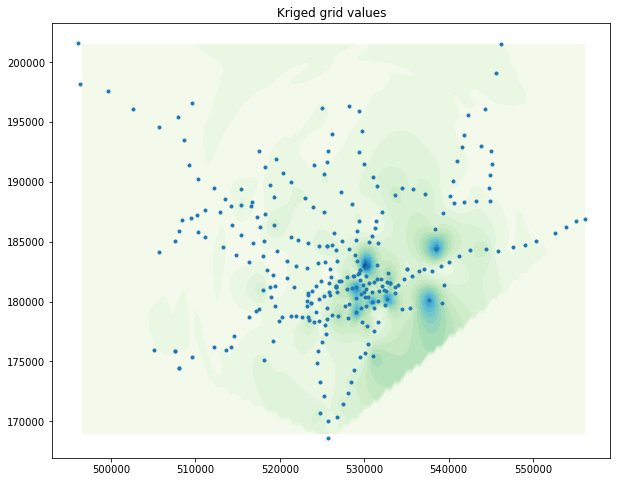

In [125]:
plt.contourf(np.unique(grid_points_pivot.columns.values), np.unique(grid_points_pivot.index.values), 
             grid_points_pivot.values/np.nanmax(grid_points_pivot.values),20,cmap='GnBu')
plt.plot(staee['EASTING'], staee['NORTHING'], '.')
plt.title('Kriged grid values')

Although `matplotlib.pyplot` can help visualize the result, but still not good enough. Because we want to compare the differences from original map, and get the interpolated results shown with `folium` as well, so we can do the final task as: 

In [126]:
def color_function(value):
    if (value==0) | (value==np.nan) : return (0,0,0,0)
    else: 
        color = mpl.cm.YlOrRd(value) 
        return color

### <a id="Task 9">Task 9<a/>

Now as we are going to call the interactive map again for final visualisation, which means we need to change the geometry for interpolated points from EPSG27700 into WGS84 (EPSG 4326).

In [128]:
grid_points_gpd = grid_points.set_geometry('geometry')
grid_points_gpd.crs = {'init':'epsg:27700'}
grid_points_gpd = grid_points_gpd.to_crs({'init': 'epsg:4326'})
grid_points_gpd['x'] = grid_points_gpd.geometry.apply(lambda x: x.x)
grid_points_gpd['y'] = grid_points_gpd.geometry.apply(lambda x: x.y)

In [131]:
from folium import raster_layers
# same base map as task 8
# mean_long = np.mean(grid_points_gpd['x'] )
# mean_lat = np.mean(grid_points_gpd['y'] )

m = folium.Map([mean_lat, mean_long], zoom_start=10, tiles='Stamen Toner')

m.add_children(scale)
# the interpolation layer added
m.add_children(raster_layers.ImageOverlay(image = (grid_points_pivot.values/np.nanmax(grid_points_pivot.values)), 
                                    bounds = [[np.min(grid_points_gpd['y']), np.min(grid_points_gpd['x'])],
                                            [np.max(grid_points_gpd['y']), np.max(grid_points_gpd['x'])]], 
                                    opacity=0.7,origin='lower', colormap=color_function))
# plot the same markers as task 8
# plot the circle markers
for row in data_lat_long.iterrows():
    folium.CircleMarker(location=[row[1]['lat'], row[1]['long']], radius=10, color=None, fill_opacity=0.7,
                    fill_color=scale(row[1]['Entry_MTT'])).add_to(m)
m

## Credits!

#### Contributors:
The following individual(s) have contributed to these teaching materials: Yijing Li (yijing.li@kcl.ac.uk).

#### License
These teaching materials are licensed under a mix of [The MIT License](https://opensource.org/licenses/mit-license.php) and the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/).